# **Moving to ResNets**

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import pickle, gzip, math, os, time, shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torch
from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

## **Setup**

In [16]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 1024
x_mean, x_std = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o) - x_mean) / x_std for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [17]:
# Activations with our trusty General RelU
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [18]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

## **Moving Toward Deeper Architectures**

Prior to moving onto ResNets, we can experiment with increasing the depth of our ConvNet model. This should be possible since we were initializing our weights pretty effectively while using BatchNorm.

Previously, we had a model which peaked at 64 output channels / filters. To increase output filters to 128, we can:
1. Set the inputs and outputs to `conv(1, 8)` with a stride of 1.
2. This would allow the network to be deeper and wider as a result.

In [19]:
# for comparison
??get_model

Signature:
get_model(
    act=<class 'torch.nn.modules.activation.ReLU'>,
    nfs=None,
    norm=None,
)
Docstring: <no docstring>
Source:   
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)
File:      ~/nbs/course22p2/miniai/init.py
Type:      function

In [20]:
# Updating the get_model() function for additional filters.
def get_model(act=nn.ReLU, nfs=(8, 16, 32, 64, 128), norm=nn.BatchNorm2d):
    # initialize the first layer separately to have a wider and deeper network
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

In [21]:
set_seed(42)

lr, epochs = 6e-2, 5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
 # Adding the scheduler
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.809,0.692,0,train
0.829,0.535,0,eval
0.887,0.328,1,train
0.872,0.361,1,eval
0.907,0.259,2,train
0.894,0.291,2,eval
0.925,0.210,3,train
0.912,0.250,3,eval
0.942,0.168,4,train
0.919,0.232,4,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


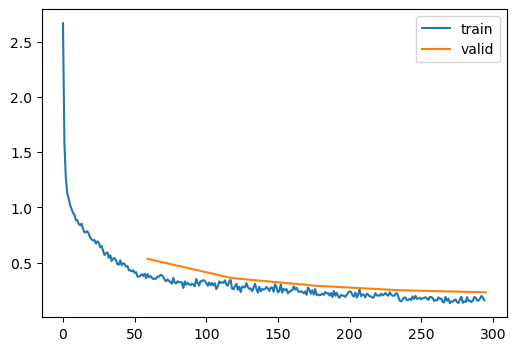

In [22]:
learn.fit(epochs)

We've hit **`91.9%`** with the simple addition of one line of code in `get_model()` which allows us to go from 8 to 128 filters. But we've also reached an inflection point i.e. adding additional width and depth will start becoming an exercise with diminishing returns.

## **Skip Connections - The Core of ResNets**

ResNets (Residual Networks) were introduced by Kaiming He et al. in 2015, in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385). 

![title](imgs/kaiming.png)

The abstract states:

> Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. We provide comprehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. On the ImageNet dataset we evaluate residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. We also present analysis on CIFAR-10 with 100 and 1000 layers.

Experiments showed that training deeper (56 layers vs. 20 layers) networks, began resulting in higher errors. The main insight was that _skip/shortcut connections_ allowed deeper networks to train successfully - while retaining the training dynamics of much shallower networks. 